<a href="https://colab.research.google.com/github/beangoben/deep_learning_escuela_verano_19/blob/master/notebooks/1_densa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red neuronal densa
Una red neuronal está compuesta por una capa de entrada, una o más capas ocultas y una capa de salida. Cada neurona en una capa de una red neuronal densa recibe conexiones de cada salida de la capa anterior. Veámos cómo programar una usando Tensorflow 2.0 con la interfaz de Keras. 

La tarea que vamos a realizar es la clasificación de ropa usando la base de datos [Fashion MNIST](https://arxiv.org/abs/1708.07747), la cual consiste de 60,000 imágenes de entrenamiento y 10,000 de prueba asociadas a 10 categorías de ropa.

| **Etiqueta**| **Categoría** |
| ------------- |:-------------:| 
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Angle boot|

Todas las imágenes son de $28 \times 28$ pixeles en escala de grises. Algunos ejemplos se muestran a continuación:

![Fashion MNIST](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)

In [0]:
etiquetas = ["T-shirt/top",
             "Trouser",    
             "Pullover",   
             "Dress",      
             "Coat",       
             "Sandal",      
             "Shirt",       
             "Sneaker",     
             "Bag",         
             "Ankle boot"]

Keras cuenta con funciones nativas para descargar las particiones de entrenamiento y prueba de esta base de datos:

In [2]:
!pip install tensorflow==2.0.0-beta1
from tensorflow.keras.datasets import fashion_mnist

(X_ent, y_ent), (X_prueba, y_prueba) = fashion_mnist.load_data()

print(X_ent.shape)
print(X_prueba.shape)

(60000, 28, 28)
(10000, 28, 28)


Ya descargadas las imágenes, podemos visualizar algunas para ver cómo lucen:

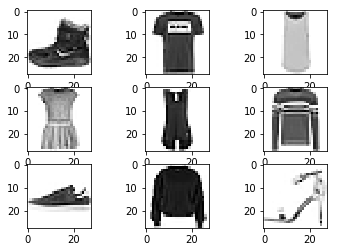

In [3]:
import matplotlib.pyplot as plt
plt.subplot(331)
plt.imshow(X_ent[0], cmap='Greys')
plt.subplot(332)
plt.imshow(X_ent[1], cmap='Greys')
plt.subplot(333)
plt.imshow(X_ent[2], cmap='Greys')
plt.subplot(334)
plt.imshow(X_ent[3], cmap='Greys')
plt.subplot(335)
plt.imshow(X_ent[4], cmap='Greys')
plt.subplot(336)
plt.imshow(X_ent[5], cmap='Greys')
plt.subplot(337)
plt.imshow(X_ent[6], cmap='Greys')
plt.subplot(338)
plt.imshow(X_ent[7], cmap='Greys')
plt.subplot(339)
plt.imshow(X_ent[8], cmap='Greys')


Como se mencionó, las imágenes son de $28 \times 28$ pixeles en escala de grises. Sin embargo, para poder alimentar nuestra red neuronal densa con las imágenes es necesario vectorizarlas. 

In [4]:
X_ent = X_ent.reshape(X_ent.shape[0], 784)
X_prueba = X_prueba.reshape(X_prueba.shape[0], 784)
print(X_ent.shape)
print(X_prueba.shape)

(60000, 784)
(10000, 784)


Cada entrada sería un vector de 784 dimensiones con posibles valores de 0 a 255 que representan una intensidad de gris. En la capa de entrada tendríamos todos los pixeles de la imagen más un 1 correspondiente al sesgo. 

Es conveniente normalizar los valores de las imágenes para que estén en el mismo rango, ya que los algoritmos de aprendizaje pueden ser sensibles. 

In [5]:
import numpy as np 

print(np.min(X_ent))
print(np.max(X_ent))
print(np.min(X_prueba))
print(np.max(X_prueba))
X_ent = X_ent / 255
X_prueba = X_prueba / 255
print(np.min(X_ent))
print(np.max(X_ent))
print(np.min(X_prueba))
print(np.max(X_prueba))


0
255
0
255
0.0
1.0
0.0
1.0


Es hora de definir nuestra arquitectura. Vamos a crear una red neuronal densa con 1 capa oculta. Para esta tarea, el número de neuronas en la capa de salida debe ser 10 debido a que tenemos 10 clases diferentes. Las salidas de estas neuronas se conectan a una función de activación softmax compartida. En las neuronas de la capa oculta ocuparemos la función de activación ReLU, que se define de la siguiente manera:

$
\phi(z) = \max(0, z)
$


Keras provee funciones y clases genéricas para distintos tipos de capas, cuyos argumentos nos permiten controlar algunos , como el número de neuronas o el tipo de función de activación. En particular, para capas denses contamos con `Dense`. 

In [0]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

inputs = Input(shape=(X_ent.shape[1],), name='ropa')
dense = Dense(30, activation='relu')(inputs)
outputs = Dense(10, activation='softmax')(dense)

model = Model(inputs=inputs, outputs=outputs, name='clasificador_ropa')

¡Listo! Ya hemos definido nuestra arquitectura de red neuronal densa. Imprimamos el resumen para verificar que haya quedado como lo pensamos y para conocer el número de parámetros.

In [7]:
model.summary()

Model: "clasificador_ropa"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ropa (InputLayer)            [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 30)                23550     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
_________________________________________________________________


Podemos también dibujar un diagrama de bloques de nuestra red con la función `plot_model` de Keras.

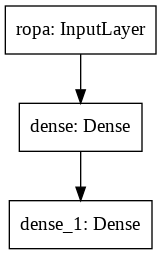

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'mi_arq.png')

Para entrenar nuestra red neuronal densa necesitamos especificar la función de pérdida y la métrica de evaluación. Como estamos tratando con una tarea de clasificación multiclase, vamos a utilizar la entropía cruzada categórica:

$
      ECC = -\left[\sum_{i=1}^N\sum_{k=1}^K 1\{y^{(i)}=k\}\log \frac{e^{z_k}}{\sum_j e^{z_j}}\right]
$

Para evaluar el modelo aprendido usaremos con la métrica de exactitud, la cual expresa la fracción de aciertos.

Esta configuración la especificamos en Keras con el método `compile` de `Model`.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate = 0.01),
              metrics=['accuracy'])

Una estrategia común para evitar que el modelo sobreajuste es hacer un paro temprano del entrenamiento y guardar el modelo que mejor desempeño tenga en el conjunto de validación. En Keras podemos hacer esto a través de un `callback` llamado `EarlyStopping`. Definimos la pérdida en validación como la cantidad a monitorear usando el argumento `monitor = 'val_loss'`. Con el argumento `patience` podemos especificar un número de épocas a esperar que esta cantidad no mejore para parar el entrenamiento. Finalmente, el argumento `restore_best_weights = True` recupera el modelo que menor pérdida obtuvo en el conjunto de validación.


In [0]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=5, mode='auto', baseline=None, restore_best_weights=True)

Ahora lanzamos el entrenamiento de nuestra red neuronal densa con el método `fit` de `Model`. Aquí, debemos especificar el tamaño del lote, el número de épocas, qué fracción de los datos usar como conjunto de validación y los `callback` del paro temprano y de Tensorboard. 

La función `to_categorical` de Keras, convierte cada etiqueta (0, 1, ..., 9) a un vector binario de tamaño $K$ igual al número de categorías existentes, cuyos elementos son todos 0 excepto el de la categoría correspondiente (por ej. la codificación de la categoría 1 de 3 posibles sería $[1, 0, 0]$). de K dimensiones con todos los valores 0 excepto. Esta es la manera en la que Keras representa la salida deseada para compararla con la predicción del modelo durante el entrenamiento.

In [11]:
from tensorflow.keras.utils import to_categorical
history = model.fit(X_ent, to_categorical(y_ent),
                    batch_size = 128,
                    epochs = 100,
                    validation_split = 0.1,
                    callbacks=[es])

W0624 10:00:59.750870 140244828383104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 2s 32us/sample - loss: 1.3602 - accuracy: 0.5833 - val_loss: 0.8896 - val_accuracy: 0.7083
Epoch 2/100
54000/54000 [==============================] - 1s 24us/sample - loss: 0.7871 - accuracy: 0.7428 - val_loss: 0.7010 - val_accuracy: 0.7707
Epoch 3/100
54000/54000 [==============================] - 1s 25us/sample - loss: 0.6703 - accuracy: 0.7793 - val_loss: 0.6282 - val_accuracy: 0.7878
Epoch 4/100
54000/54000 [==============================] - 1s 24us/sample - loss: 0.6133 - accuracy: 0.7968 - val_loss: 0.5873 - val_accuracy: 0.7968
Epoch 5/100
54000/54000 [==============================] - 1s 24us/sample - loss: 0.5766 - accuracy: 0.8076 - val_loss: 0.5620 - val_accuracy: 0.8067
Epoch 6/100
54000/54000 [==============================] - 1s 24us/sample - loss: 0.5509 - accuracy: 0.8142 - val_loss: 0.5458 - val_accuracy: 0.8110
Epoch 7/100
54000/54000 [==========================

Ya entrenado nuestro modelo, procedemos a evaluar su desempeño en el conjunto de imágenes de prueba.

In [12]:
metricas_prueba = model.evaluate(X_prueba, to_categorical(y_prueba), verbose=0)
print(u'Pérdida de prueba:', metricas_prueba[0])
print(u'Exactitud de prueba:', metricas_prueba[1])

Pérdida de prueba: 0.4011519235610962
Exactitud de prueba: 0.8574


Finalmente, visualizamos algunos ejemplos de predicciónes hechas por el modelo en el conjunto de prueba.

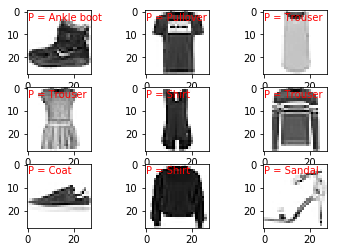

In [13]:
y_hat = model.predict(X_prueba)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_ent[i].reshape(28,28), cmap='Greys')
    prediccion = np.argmax(y_hat[i])
    plt.text(0, 4, 'P = ' + etiquetas[prediccion], fontsize=10, color = 'red')